In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from src.data_processor import DataProcessor

engine = DataProcessor(raw_data='../data/raw', processed_data='../data/processed/')
engine.load_data()


df_trans = engine.df_trans
df_prod = engine.df_prod
df_cust = engine.df_cust

engine.merge_data()
df = engine.df_master
print(f"Master Table Columns: {df.columns.tolist()}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Data loaded successfully.
📦 Processed data found at ../data/processed/master_analytical_file.csv. Loading existing file...
✅ Loaded 1,983,549 records from disk.
Master Table Columns: ['id', 'order_id', 'trade_account_id', 'item_number', 'shipped_dt', 'origin', 'type', 'netrevenue', 'quantity', 'business_type', 'created_at', 'region', 'price_usd', 'arrival_date', 'category_name', 'color_name', 'classification', 'subclass', 'scale', 'color_family', 'motif']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
audit_summary = pd.DataFrame({
    "Table": ["Transactions", "Products", "Customers"],
    "Rows": [len(df_trans), len(df_prod), len(df_cust)],
    "Columns": [len(df_trans.columns), len(df_prod.columns), len(df_cust.columns)],
    "Memory (MB)": [
        df_trans.memory_usage(deep=True).sum() / 1024**2,
        df_prod.memory_usage(deep=True).sum() / 1024**2,
        df_cust.memory_usage(deep=True).sum() / 1024**2
    ]
})
print(audit_summary)

          Table     Rows  Columns  Memory (MB)
0  Transactions  1983549        9   527.509587
1      Products    16064       10     8.014843
2     Customers    29691        4     5.410880


In [9]:
print("--- TRANSACTIONS DTYPES & NULLS ---")
print(df_trans.dtypes)
print(df_trans.isnull().sum())

print("\n--- ITEM MASTER DTYPES & NULLS ---")
print(df_prod.dtypes)
print(df_prod.isnull().sum())

print("\n--- CUSTOMER DTYPES & NULLS ---")
print(df_cust.dtypes)
print(df_cust.isnull().sum())

--- TRANSACTIONS DTYPES & NULLS ---
id                    int64
order_id              int64
trade_account_id      int64
item_number          object
shipped_dt           object
origin               object
type                 object
netrevenue          float64
quantity            float64
dtype: object
id                  0
order_id            0
trade_account_id    0
item_number         0
shipped_dt          0
origin              0
type                0
netrevenue          0
quantity            0
dtype: int64

--- ITEM MASTER DTYPES & NULLS ---
item_number        object
price_usd         float64
arrival_date       object
category_name      object
color_name         object
classification     object
subclass           object
scale              object
color_family       object
motif              object
dtype: object
item_number          0
price_usd          252
arrival_date         0
category_name        0
color_name           3
classification      22
subclass           214
scale           

In [ ]:
# Item Number Check
trans_items = set(df_trans['item_number'].unique())
prod_items = set(df_prod['item_number'].unique())
orphans = trans_items - prod_items

print(f"Unique Items in Transactions: {len(trans_items):,}")
print(f"Unique Items in Product Master: {len(prod_items):,}")
print(f"Orphan Items (Sold but not in Master): {len(orphans):,}")

# Customer ID Check
trans_custs = set(df_trans['trade_account_id'].unique())
cust_master = set(df_cust['trade_account_id'].unique())
orphan_custs = trans_custs - cust_master
print(f"Orphan Customers: {len(orphan_custs):,}")

Unique Items in Transactions: 13,721
Unique Items in Product Master: 16,064
❌ Orphan Items (Sold but not in Master): 0
❌ Orphan Customers: 0


In [11]:
# Check for leading/trailing spaces
trans_spaces = df_trans['item_number'].astype(str).str.contains(r'^\s|\s$').sum()
prod_spaces = df_prod['item_number'].astype(str).str.contains(r'^\s|\s$').sum()

print(f"Transaction items with spaces: {trans_spaces}")
print(f"Product items with spaces: {prod_spaces}")

# ACTION: Sanitize if necessary
if trans_spaces > 0 or prod_spaces > 0:
    df_trans['item_number'] = df_trans['item_number'].astype(str).str.strip().str.upper()
    df_prod['item_number'] = df_prod['item_number'].astype(str).str.strip().str.upper()
    print("✅ Keys Sanitized.")

Transaction items with spaces: 0
Product items with spaces: 0


In [12]:
# 1. Sales with $0 revenue
zero_rev = df_trans[(df_trans['type'] == 'PRODUCT') & (df_trans['netrevenue'] == 0)].shape[0]

# 2. Duplicate order_ids (Are items split across rows?)
dupe_orders = df_trans.duplicated(subset=['order_id', 'item_number']).sum()

# 3. Date range check
date_min = df_trans['shipped_dt'].min()
date_max = df_trans['shipped_dt'].max()

print(f"Logical Audit Results:")
print(f"- Sales with $0 Revenue: {zero_rev}")
print(f"- Duplicate Order-Item rows: {dupe_orders}")
print(f"- Data Timeline: {date_min} to {date_max}")

Logical Audit Results:
- Sales with $0 Revenue: 248
- Duplicate Order-Item rows: 1421
- Data Timeline: 2025-01-01 00:00:00.275 to 2025-12-31 21:40:11.000


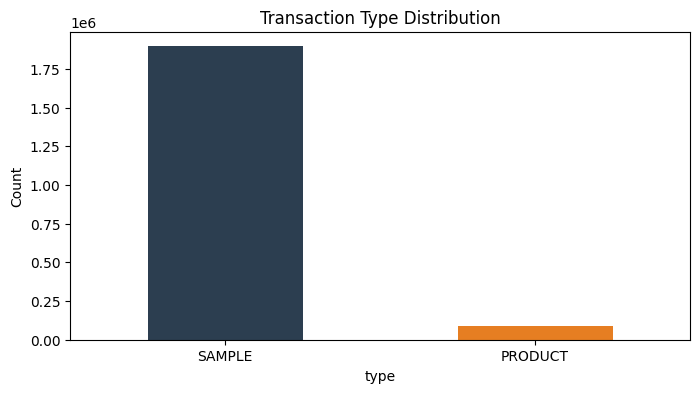

In [13]:
plt.figure(figsize=(8, 4))
df_trans['type'].value_counts().plot(kind='bar', color=['#2c3e50', '#e67e22'])
plt.title('Transaction Type Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()